In [1]:
%matplotlib nbagg
import time
start_time = time.time()

# Variance of SAXS data

There has been a long discussion about the validity (or not) of pixel splitting regarding the propagation of errors [#520](https://github.com/silx-kit/pyFAI/issues/520) [#882](https://github.com/silx-kit/pyFAI/issues/882) [#883](https://github.com/silx-kit/pyFAI/issues/883).
So we will develop a mathematical model for a SAXS experiment and validate it in the case of a SAXS approximation (i.e. no solid-angle correction, no polarisation effect, and of course small angled $\theta = sin(\theta) = tan(\theta)$)

## System under study

Let's do a numerical experiment, simulating the following experiment:

* Detector: 1024x1024 square pixels of 100µm each, assumed to be poissonian. 
* Geometry: The detector is placed at 1m from the sample, the beam center is in the corner of the detector
* Intensity: the maximum signal on the detector is 10 000 photons per pixel, each pixel having a minimum count of a hundreed.
* Wavelength: 1 Angstrom
* During the first part of the studdy, the solid-angle correction will be discarded, same for solid angle corrections.
* Pixel splitting is disables, for this we use one of the folloging rebinning engines:
  - numpy: the slowest available in pyFAI
  - histogram: implemented in cython
  - nosplit_csr: using a look-up table
  - nosplit_csr_ocl_gpu: which offloads the calculation on the GPU.
  
  We will check they all provide the same numerical result
  
Now we define some constants for the studdy. The dictionary *kwarg* contains the parameters used for azimuthal integration. This ensures the number of bins for the regrouping or correction like $\Omega$ and polarization are always the same.

In [2]:
pix = 100e-6
shape = (1024, 1024)
npt = 1000
nimg = 1000
wl = 1e-10
I0 = 1e4
Rg = 1.
kwarg = {"npt":npt, 
         "correctSolidAngle":False, 
         "polarization_factor":None,
         "safe":False}


In [3]:
import numpy
from scipy.stats import chi2 as chi2_dist
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
import pyFAI
print(pyFAI.version)
from pyFAI.detectors import Detector
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui import jupyter
detector = Detector(pix, pix)
detector.shape = detector.max_shape = shape
print(detector)

0.16.0-beta0
Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m


We define in *ai_init* the geometry, the detector and the wavelength. 

In [4]:
ai_init = {"dist":1.0, 
           "poni1":0.0, 
           "poni2":0.0, 
           "rot1":0.0,
           "rot2":0.0,
           "rot3":0.0,
           "detector":detector, 
           "wavelength":wl}
ai = AzimuthalIntegrator(**ai_init)
print(ai)          

#Solid consideration:
Ω  = ai.solidAngleArray(detector.shape, absolute=True)

print("Solid angle: maxi= {} mini= {}, ratio= {}".format(Ω.max(), Ω.min(), Ω.min()/Ω.max()))

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 0.000000e+00, 0.000000e+00m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1000.000mm	Center: x=0.000, y=0.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
Solid angle: maxi= 9.999999925000007e-09 mini= 9.693768051738431e-09, ratio= 0.9693768124441685


<IPython.core.display.Javascript object>


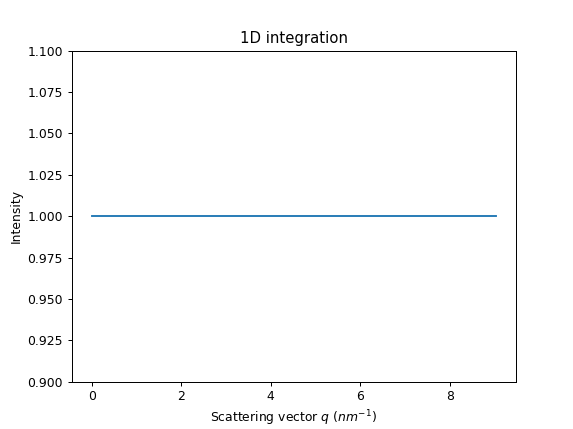

(0.9, 1.1)

In [5]:
# Validation of the flatness of a flat image integrated
flat = numpy.ones(detector.shape)
res_flat = ai.integrate1d(flat, **kwarg)
crv = jupyter.plot1d(res_flat)
crv.axes.set_ylim(0.9,1.1)

In [6]:
#Equivalence of different rebinning engines:

for method in "numpy", "histogram", "nosplit_csr", "nosplit_csr_ocl_gpu":
    ai.reset()
    res_flat = ai.integrate1d(flat, method=method, **kwarg)
    print("timeit for method=", method, "max error:", abs(res_flat.intensity-1).max())
    % timeit res_flat = ai.integrate1d(flat, method=method, **kwarg)

timeit for method= numpy max error: 0.0
42.5 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
timeit for method= histogram max error: 0.0


22.9 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
timeit for method= nosplit_csr max error: 0.0


1.37 ms ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
timeit for method= nosplit_csr_ocl_gpu max error: 1.1920929e-07
1.52 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
# so we chose the nosplit_csr_ocl_gpu, other methods may be faster depending on the computer
kwarg["method"] = "nosplit_csr_ocl_gpu"

<IPython.core.display.Javascript object>


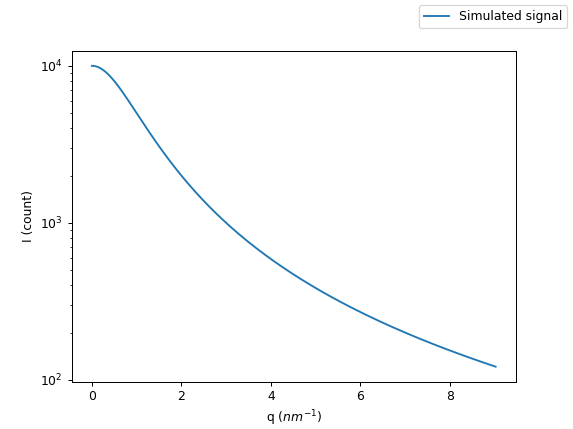

In [8]:
# Generation of a "SAXS-like" curve with the shape of a lorentzian curve

q = numpy.linspace(0, res_flat.radial.max(), npt)
I = I0/(1+q**2)
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
fig.legend()

<IPython.core.display.Javascript object>


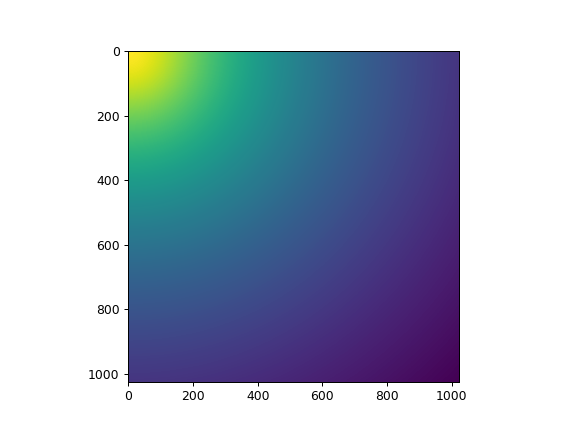

In [9]:
#Reconstruction of diffusion image:

img_theo = ai.calcfrom1d(q, I, dim1_unit="q_nm^-1", 
                         correctSolidAngle=False, 
                         polarization_factor=None)
fig, ax = subplots()
ax.imshow(img_theo, norm=LogNorm())

<IPython.core.display.Javascript object>


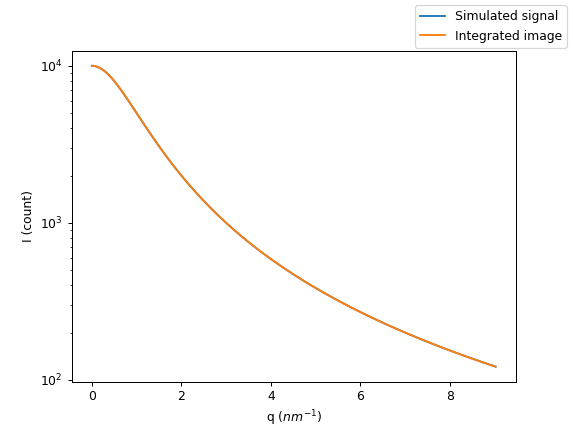

In [10]:
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
res = ai.integrate1d(img_theo, **kwarg)
ax.plot(*res, label="Integrated image")

#Display the error: commented as it makes the graph less readable
#I_bins = I0/(1+res.radial**2)
#ax.plot(res.radial, abs(res.intensity-I_bins), label="error")
fig.legend()

## Construction of a synthetic dataset

We construct now a synthetic dataset of thousand images of this reference image with a statistical distribution which is common for photon-counting detectors (like Pilatus or Eiger): The Poisson distribution. The signal is between 100 and 10000, so every pixel should see photons and there is should be no "rare-events" bias (which sometimes occures in SAXS).

### Poisson distribution:
The Poisson distribution has the peculiarity of having its variance equal to the signal, hence the standard deviation equals to the square root of the signal. 


**Nota:** the generation of the images is slow and takes about 1Gbyte of memory !


In [11]:
%%time

if "dataset" not in dir():
    dataset = numpy.random.poisson(img_theo, (nimg,) + img_theo.shape)
# else avoid wasting time
print(dataset.size/(1<<20), "MBytes", dataset.shape)

1000.0 MBytes (1000, 1024, 1024)
CPU times: user 1min 21s, sys: 1.6 s, total: 1min 22s
Wall time: 1min 22s


### Validation of the Poisson distribution.

We have now thousand images of one magapixel. It is interesting to validate if the distribution actually follows the Poisson distribution. For this we will check if the *signal* and its *variance* follow a $\chi^2$ distribution. 

For every pair of images I and J we calculate the numerical value of $\chi ^2$:

$$
\chi^2 = \frac{1}{nbpixel-1}\sum_{pix}\frac{(I_{pix} - J_{pix})^2}{\sigma(I_{pix})^2 + \sigma(J_{pix})^2)}
$$

The distibution is obtained by calculating the histogram of $\chi^2$ values for every pair of images, here almost half a milion. 

The calculation of the $\chi^2$ value is likely to be critical in time, so we will shortly investigate 3 implementation: *numpy* (fail-safe but not that fast), *numexp* and *numba*
Do not worry if any of the two later method fail: they are faster but provide the same numerical result as numpy.

In [12]:
print("Number of paires of images: ", nimg*(nimg-1)//2)

Number of paires of images:  499500


In [13]:
#Numpy implementation of Chi^2 measurement for a pair of images. Fail-safe implementation

def chi2_images_np(I, J):
    """Calculate the Chi2 value for a pair of images with poissonnian noise 
    Numpy implementation"""
    return ((I-J)**2/(I+J)).sum()/(I.size - 1)

img0 = dataset[0]
img1 = dataset[1]
print(chi2_images_np(img0, img1))
%timeit chi2_images_np(img0, img1)

0.9995950907530075
6.95 ms ± 8.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
#Numexp implementation of Chi^2 measurement for a pair of images. 
from numexpr import NumExpr
expr = NumExpr("((I-J)**2/(I+J))", signature=[("I", numpy.float64),("J", numpy.float64)])

def chi2_images_ne(I, J):
    """Calculate the Chi2 value for a pair of images with poissonnian noise
    NumExpr implementation"""
    return expr(I, J).sum()/(I.size-1)

img0 = dataset[0]
img1 = dataset[1]
print(chi2_images_ne(img0, img1))
%timeit chi2_images_ne(img0, img1)

#May fail if numexpr is not installed, but gives the same numerical value, just faster

0.9995950907530075
1.71 ms ± 47.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
#Numba implementation of Chi^2 measurement for a pair of images. 
from numba import jit

@jit
def chi2_images_nu(img1, img2):
    """Calculate the Chi2 value for a pair of images with poissonnian noise
    Numba implementation"""
    I = img1.ravel()
    J = img2.ravel()
    l = len(I)
    assert len(J) == l
    #version optimized for JIT
    s = 0.0
    for i in range(len(I)):
        a = float(I[i])
        b = float(J[i])
        s+= (a-b)**2/(a+b)
    return s/(l-1)

img0 = dataset[0]
img1 = dataset[1]
print(chi2_images_nu(img0, img1))
%timeit chi2_images_nu(img0, img1)

#May fail if numba is not installed. 
# The numerical value, may differ due to reduction algorithm used, should be the fastest.

0.9995950907527901
1.4 ms ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
# Select the prefered algorithm for calculating the numerical value of chi^2 for a pair of images.
chi2_images = chi2_images_ne

In [17]:
%%time 

#Calculate the numerical value for chi2 for every pair of images. This takes a while

c2i = []
for i in range(nimg):
    img1 = dataset[i]
    for j in range(i):
        c2i.append(chi2_images(img1, dataset[j]))
c2i = numpy.array(c2i)

CPU times: user 1h 4min 19s, sys: 44.8 s, total: 1h 5min 4s
Wall time: 15min 14s


<IPython.core.display.Javascript object>


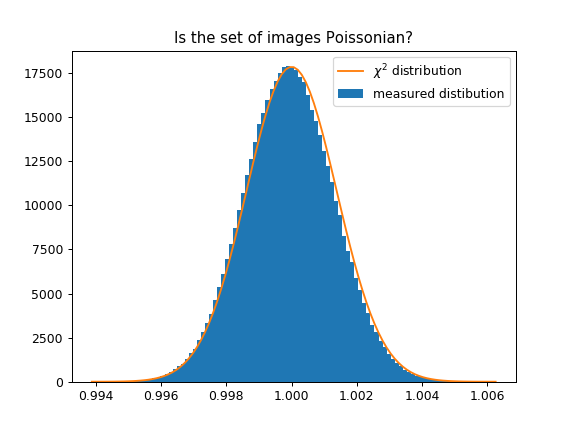

In [18]:
fig, ax = subplots()
h,b,_ = ax.hist(c2i, 100, label="measured distibution")
ax.plot()
size = numpy.prod(shape)
y_sim = chi2_dist.pdf(b*(size-1), size)
y_sim *= h.sum()/y_sim.sum()
ax.plot(b, y_sim, label=r"$\chi^2$ distribution")
ax.set_title("Is the set of images Poissonian?")
ax.legend()

This validates the fact that our set of image is actually a Poissonian distribution around the target image displayed in figure 3.

# Integration of images in the SAXS appoximation:

We can now integrate all images and check wheather all pairs of curves (with their associated error) fit or not the $\chi^2$ distribution. 

It is important to remind that we stay in SAXS approximation, i.e. no solid angle correction or other position-dependent normalization. The pixel splitting is also disabled. So the azimuthal integration is simply:

$$
I_{bin} = \frac{1}{count(pix\in bin)} \sum_{pix \in bin} I_{pix}
$$

The number of bins in the curve being much smaller than the number of pixel in the input image, this calculation is less time-critical. So we simply define the same kind of $\chi^2$ function using numpy.

In [19]:
def chi2_curves(res1, res2):
    """Calculate the Chi2 value for a pair of integrated data"""
    I = res1.intensity
    J = res2.intensity
    l = len(I)
    assert len(J) == l
    sigma_I = res1.sigma
    sigma_J = res2.sigma
    return ((I-J)**2/(sigma_I**2+sigma_J**2)).sum()/(l-1)

In [20]:
%%time
#Perform the azimuthal integration of every single image

integrated = []
for i in range(nimg):
    data = dataset[i, :, :]
    integrated.append(ai.integrate1d(data, variance=data, **kwarg))


CPU times: user 3.49 s, sys: 141 ms, total: 3.63 s
Wall time: 3.61 s


In [21]:
#Check if chi^2 calculation is time-critical:
%timeit chi2_curves(integrated[0], integrated[1])

10.3 µs ± 24 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
c2 = []
for i in range(nimg):
    res1 = integrated[i]
    for j in range(i):
        c2.append(chi2_curves(res1, integrated[j]))
c2 = numpy.array(c2)

<IPython.core.display.Javascript object>


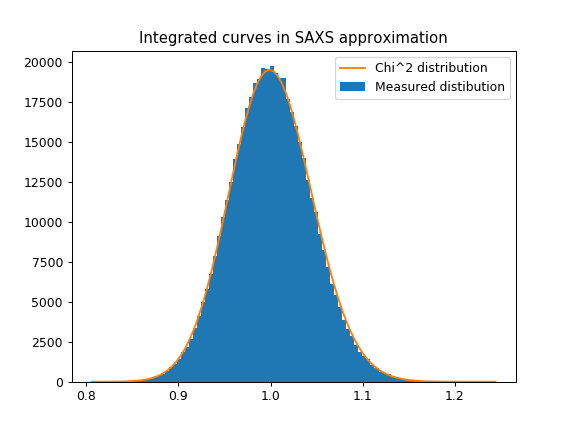

In [23]:
fig, ax = subplots()
h,b,_ = ax.hist(c2, 100, label="Measured distibution")
y_sim = chi2_dist.pdf(b*(nimg-1), nimg)
y_sim *= h.sum()/y_sim.sum()
ax.plot(b, y_sim, label=r"Chi^2 distribution")
ax.set_title("Integrated curves in SAXS approximation")
ax.legend()

In [24]:
low_lim, up_lim = chi2_dist.ppf([0.005, 0.995], nimg) / (nimg - 1)
print(low_lim, up_lim)
print("Expected outliers: ", nimg*(nimg-1)*0.005/2, "got", 
(c2<low_lim).sum(),"below and ",(c2>up_lim).sum(), "above")

0.889452976157626 1.1200681344576493
Expected outliers:  2497.5 got 2522 below and  2653 above


# Integration of images with solid angle correction/polarization correction

PyFAI applies by default solid-angle correction which is needed for powder diffraction. 
On synchrotron sources, the beam is highly polarized and one would like to correct for this effect as well. How does it influence the error propagation ? 

If we enable the solid angle normalisation (noted $\Omega$) and the polarisation correction (noted $P$), this leads us to:

$$
I_{bin} = \frac{1}{count(pix\in bin)} \sum_{pix \in bin} \frac{I_{pix}}{\Omega_{pix} P_{pix}}
$$

Flatfield correction and any other normalization like pixel efficiency related to sensor thickness should be accounted in the same way.

**Nota:** The pixel splitting remains disabled. 

<IPython.core.display.Javascript object>


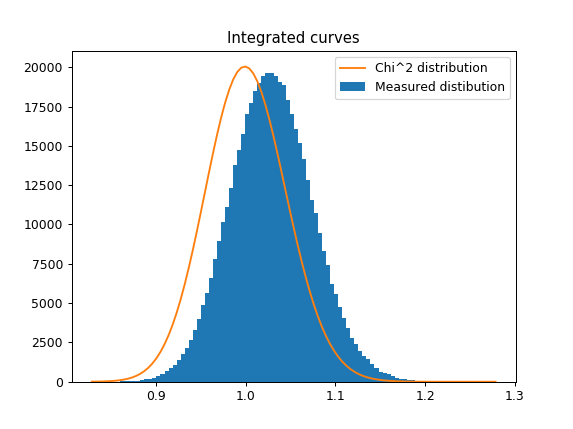

In [25]:
kwarg = {"npt":npt, 
         "method": "nosplit_csr", 
         "correctSolidAngle":True, 
         "polarization_factor":0.95,
         "safe":False}

#As we use "safe"=False, we need to reset the integrator manually:
ai.reset()

def plot_distribution(ai, kwargs, nbins=100, integrate=None):
    ai.reset()
    results = []
    c2 = []
    if integrate is None:
        integrate = ai._integrate1d_legacy
    for i in range(nimg):
        data = dataset[i, :, :]
        r = integrate(data, variance=data, **kwarg)
        results.append(r)    
        for j in range(i):
            c2.append(chi2_curves(r, results[j]))
    c2 = numpy.array(c2)
    fig, ax = subplots()
    h,b,_ = ax.hist(c2, nbins, label="Measured distibution")
    y_sim = chi2_dist.pdf(b*(nimg-1), nimg)
    y_sim *= h.sum()/y_sim.sum()
    ax.plot(b, y_sim, label=r"Chi^2 distribution")
    ax.set_title("Integrated curves")
    ax.legend()
    return fig, ax

f,a = plot_distribution(ai, kwarg)
f.show()

The normalisation of the raw signal distorts the distribution of error, even at a level of a few percent correction ! (Thanks Daniel Franke for the demonstration)

# Introducing the next generation azimuthal integrator ... pyFAI 0.16

As any normalization introduces some distortion into the error propagation, the error propagation should properly account for this. Alessandro Mirone suggested to treat normalization within azimuthal integration like this :

$$
I_{bin} = \frac{\sum_{pix \in bin} I_{pix}}{\sum_{pix \in bin} \Omega_{pix}P_{pix}}
$$

This is under investigation since begining 2017 https://github.com/silx-kit/pyFAI/issues/520 and is now available as part of pyFAI_0.16 as the ```_integrate1d_ng``` method of any ```AzimuthalIntegrator``` object. This procedure has for now lower performances than the legacy version and we hope to get the performances back for version 0.17 and make it the default behaviour.

**Nota:**
This is a major issue as almost any commercial detector comes with flatfield correction already applied on raw images; making impossible to properly propagate the error (I am especially thinking at photon counting detectors manufactured by Dectris!). The detector should then provide the actual raw-signal and the flatfield normalization to allow proper signal and error propagation.

This is a demonstration of how one can build an AzimuthalIntegrator-like class with proper error propagaton:

In [26]:
from pyFAI.containers import Integrate1dResult
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from copy import copy

class AzimuthalIntegratorNextGen(AzimuthalIntegrator):
    def integrate1d_ng(self, data, variance, **kwargs):
        """Demonstrator for the new azimuthal integrator taking care of the normalization, 
        here implemented only on the solid-angle correction"""
        kwargs = kwargs.copy()
        if kwargs["correctSolidAngle"]:
            norm = self.solidAngleArray(self.detector.shape).copy()
        else:
            norm = numpy.ones(data.shape)
        kwargs["correctSolidAngle"] = False
        polf = kwargs.get("polarization_factor")
        if polf:
            norm *= self.polarization(self.detector.shape, factor=polf)
        kwargs["polarization_factor"] = None
        flat = kwargs.get("flat")
        if flat is not None:
            norm *= flat
        kwargs["flat"] = None
        denom = self.integrate1d(norm, **kwargs)
        signal = self.integrate1d(data, **kwargs)
        sigma2 = self.integrate1d(variance, **kwargs)
        result = Integrate1dResult(denom.radial, 
                                   signal.sum/denom.sum, 
                                   numpy.sqrt(sigma2.sum)/denom.sum)
        result._set_method_called("integrate1d_ng")
        result._set_compute_engine(denom.compute_engine)
        result._set_unit(signal.unit)
        result._set_sum(signal.sum)
        result._set_count(signal.count)
        return result
    

ai2 = AzimuthalIntegratorNextGen(**ai_init)
kwarg = {"npt":npt, 
         "method": "nosplit_csr_ocl_gpu", 
         "correctSolidAngle":True, 
         "polarization_factor":0.95,
         "safe":False}

<IPython.core.display.Javascript object>


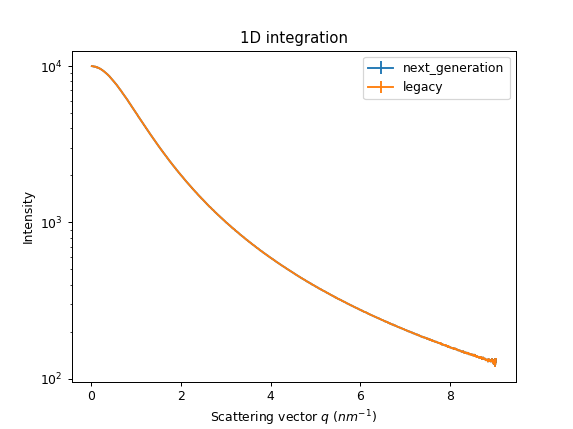

In [27]:
#The new implementation provides almost the same result as the former one:
ai.reset()
fig, ax = subplots()
data = dataset[0]
res_ng = ai._integrate1d_ng(data, variance=data, **kwarg)
jupyter.plot1d(res_ng, ax=ax, label="next_generation")
ax.set_yscale("log")
jupyter.plot1d(ai._integrate1d_legacy(data, variance=data, **kwarg), ax=ax, label="legacy")
#jupyter.plot1d(ai._integrate1d_ng(data, variance=data, **kwarg), ax=ax, label="next2")
ax.legend()

# If you zoom in enough, you will see the difference !

<IPython.core.display.Javascript object>


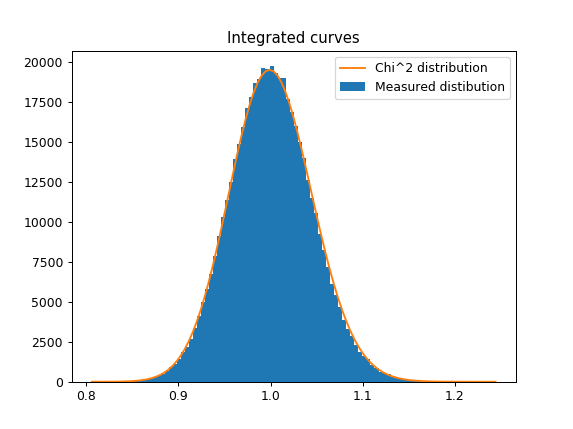

In [28]:
#Validation of the error propagation without pixel splitting but with normalization:
f,a = plot_distribution(ai, kwarg, integrate = ai._integrate1d_ng)
f.show()

# Azimuthal integration with pixel splitting

Pixels splitting is implemented in pyFAI in calculating the fraction of area every pixel spends in any bin. This is noted $c^{pix}_{bin}$. The calculation of those coeficient is done with some simple geometry but it is rather tedious, this is why two implementation exists: a simple one which assues pixels boundary are paralle to the radial and azimuthal axes called ```BBox``` for bounding box and a more precise one calculating the intersection of polygons (called ```splitpixel```. The calculation of those coefficient is what lasts during the initialization of the integrator as this piece of code is not (yet) parallelized. The total number of (complete) pixel in a bin is then simply the sum of all those coeficients: $\sum_{pix \in bin} c^{pix}_{bin}$.

The azimuthal integration used to be implemented as (pyFAI <=0.15):

$$
I_{bin} = \frac{ \sum_{pix \in bin} c^{pix}_{bin} \frac{I_{pix}}{\Omega_{pix} P_{pix}}}{\sum_{pix \in bin}c^{pix}_{bin}}
$$

With the associated error propagation (this is what is implemented in pyFAI, there is an error in it!):

$$
\sigma_{bin} = \frac{\sqrt{\sum_{pix \in bin} c^{pix}_{bin} \sigma^2_{pix}}}{\sum_{pix \in bin}c^{pix}_{bin}}
$$

We have now tools to validate the error propagation for every single rebinning engine. Let's see if pixel splitting induces some error, with coarse or fine pixel splitting:


<IPython.core.display.Javascript object>


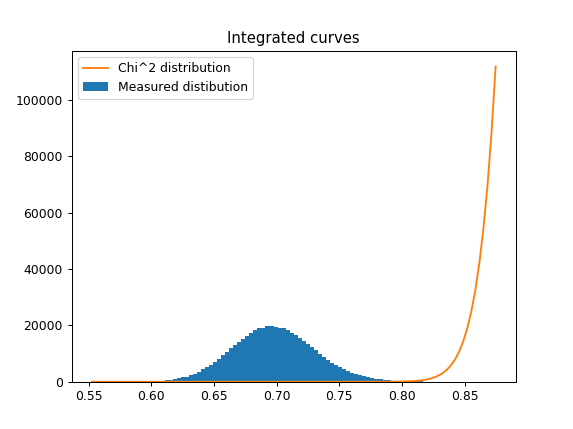

In [29]:
#With coarse pixel-splitting, new integrator:
kwarg["method"] = "csr"
f,a = plot_distribution(ai, kwarg, integrate = ai._integrate1d_ng)
f.show()

<IPython.core.display.Javascript object>


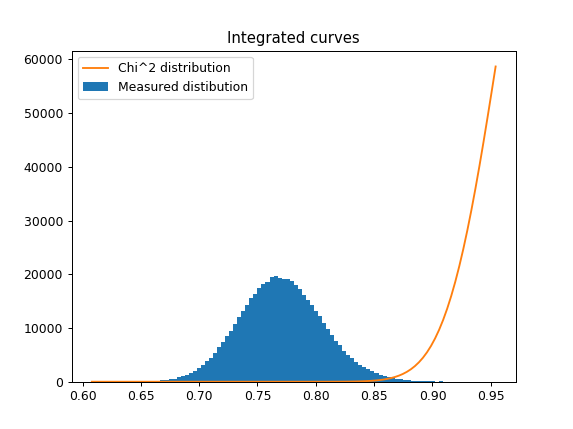

In [30]:
#With fine pixel-splitting, new integrator:
kwarg["method"] = "fullsplit_csr"
f,a = plot_distribution(ai, kwarg, integrate = ai._integrate1d_ng)
f.show()

Any kind of pixel splitting causes a change in the distribution of signal. This error has been spotted by Daniel Franke from Hamburg. If the azimuthal integration should be performed like:

$$
I_{bin} = \frac{\sum_{pix \in bin} c^{pix}_{bin}I_{pix}}{\sum_{pix \in bin} c^{pix}_{bin}\Omega_{pix}P_{pix}}
$$

the associated variance propagation should look like this: 

$$
\sigma_{bin} = \frac{\sqrt{\sum_{pix \in bin} (c^{pix}_{bin})^2 \sigma^2_{pix}}}
                     {\sum_{pix \in bin}c^{pix}_{bin}\Omega_{pix}P_{pix}}
$$

And the square of the coefficient has been missing until v0.16 of pyFAI. Updated rebinning engines contain a ```coef_power``` optional argument which allows the user to change the power applied on the coefficient, like CSR-integrators:

<IPython.core.display.Javascript object>


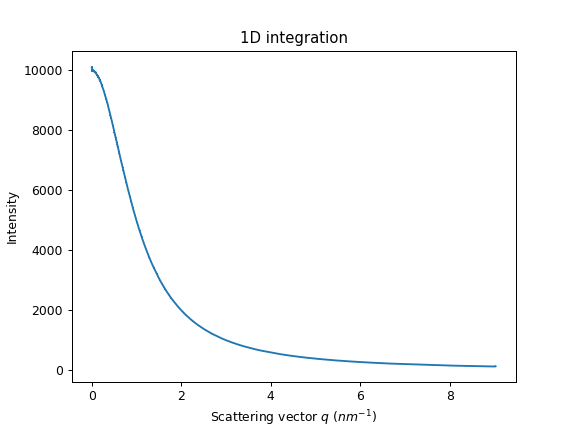

HistoBBox1d.integrate(self, weights, dummy=None, delta_dummy=None, dark=None, flat=None, solidAngle=None, polarization=None, double normalization_factor=1.0, int coef_power=1)

        Actually perform the integration which in this case looks more like a matrix-vector product

        :param weights: input image
        :type weights: ndarray
        :param dummy: value for dead pixels (optional)
        :type dummy: float
        :param delta_dummy: precision for dead-pixel value in dynamic masking
        :type delta_dummy: float
        :param dark: array with the dark-current value to be subtracted (if any)
        :type dark: ndarray
        :param flat: array with the dark-current value to be divided by (if any)
        :type flat: ndarray
        :param solidAngle: array with the solid angle of each pixel to be divided by (if any)
        :type solidAngle: ndarray
        :param polarization: array with the polarization correction values to be divided by (if any)
        :type p

In [31]:
ai.reset()
kwarg["method"] = "csr"
img = dataset[0]
fig,ax = subplots()
ref = ai.integrate1d(img, variance=img, **kwarg)
jupyter.plot1d(ref, ax=ax)
csr = ai.engines["csr_integrator"].engine
print(csr.integrate.__doc__)

With those modification available, we are now able to estimate the error propagated from one curve and compare it with the "usual" result from pyFAI:

0.9594304350043318


<IPython.core.display.Javascript object>


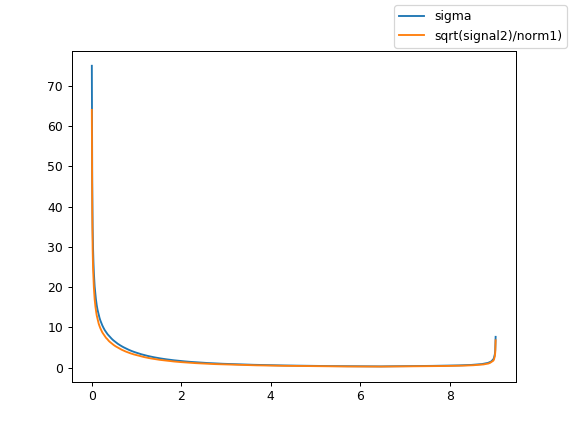

In [32]:
norm = ai.solidAngleArray(detector.shape) * ai.polarization(detector.shape, factor=0.95)
print(norm.min())
denom = csr.integrate(norm)
signal1 = csr.integrate(img)
signal2 = csr.integrate(img, coef_power=2)

fig,ax = subplots()
#ax.plot(ref.radial, ref.intensity, label="ref")
#ax.plot(denom1[0], signal1[2]/denom1[2], label="signal/norm")
ax.plot(ref.radial, ref.sigma, label="sigma")
ax.plot(denom[0], numpy.sqrt(signal2[2])/denom[2], label="sqrt(signal2)/norm1)")

fig.legend()
fig.canvas.draw()
#ax.plot(denom2[0], denom2[2])

It turns out pyFAI was slightly overestimating the error, but not by much which explains why this bug remained undiscovered for years.

We have now all the tools to build a new integrator and evaluate if it behaves as expected: (from a statistical point of view)

<IPython.core.display.Javascript object>


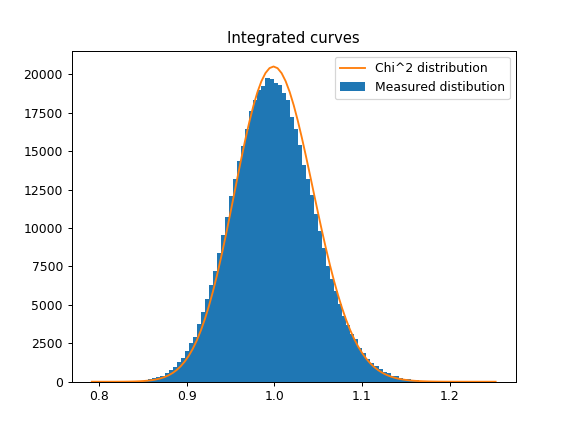

In [33]:
#Experimental 1D integrator ... 
from pyFAI.containers import Integrate1dResult
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from copy import copy

def integrate1d_experimental(self, data, variance, **kwargs):
    """Experimental azimuthal integrator"""
    if "csr_integrator" not in self.engines:
        self.integrate1d(data, **kwargs)
    csr = self.engines["csr_integrator"].engine
    
    if kwargs["correctSolidAngle"]:
        norm = self.solidAngleArray(self.detector.shape).copy()
    else:
        norm = numpy.ones(data.shape)
    polf = kwargs.get("polarization_factor")
    if polf:
        norm *= self.polarization(self.detector.shape, factor=polf)
    flat = kwargs.get("flat")
    if flat is not None:
        norm *= flat
    denom1 = csr.integrate(norm)
    signal = csr.integrate(data)
    sigma2 = csr.integrate(variance, coef_power=2)
    result = Integrate1dResult(denom1[0], 
                               signal[2]/denom1[2], 
                               numpy.sqrt(sigma2[2])/denom1[2])
    result._set_method_called("integrate1d_exp")
    result._set_compute_engine("experimental")
    return result

#I would usually not recommand monkey-patching, but it is convieniant here for demonstration purpose
ai.__class__.integrate1d_experimental = integrate1d_experimental


f,a = plot_distribution(ai, kwarg, integrate=ai.integrate1d_experimental)
f.show()

The integrated curves are now following the $\chi^2$ distribution, which means that the errors provided are in accordance with the data.

# Conclusion

PyFAI's historical version (version <=0.16) has been providing proper error propagation ONLY in the case where any normalization (solid angle, flatfield, polarization, ...) and pixel splitting was DISABLED. 
This is not the most common use-case for pyFAI I have to confess. We demonstrate in this notebook how to fix the two bugs. For implementing this in pyFAI, many thousands of line of code needs to be changed and all associated test, which was not be possible before the release of pyFAI v0.16. But for scientific honesty I prefer warning the users of the implication and offer them the tools to validate the code.

Moreover the fact the normalization has to be performed as part of the integration is a major issue as almost any commercial detector comes with flatfield correction already applied.



In [34]:
print("Total execution time: ", time.time()-start_time)

Total execution time:  1153.526174068451
